# Load Libraries

In [2]:
#from sentence_transformers import SentenceTransformer, util
import pandas as pd
import seaborn as sns
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection,  svm
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
from tqdm import tqdm

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings('ignore')
np.random.seed(107)

In [2]:
twitter_files = glob.glob(r"C:\Users\Mao\sharedfiles\P Data\*.csv")

In [3]:
twitter_files = sorted(twitter_files)
full_data = pd.DataFrame()
for files in twitter_files:
    data = pd.read_csv(files,low_memory=False)[['UniversalMessageId','SenderScreenName','OriginalAuthor','Message','MessageType','citizen_distance','Day']]
    full_data = full_data.append(data)

In [4]:
full_data['message_cleaned'] = full_data.Message.str.replace(r'(RT @.*?\s)','')

In [5]:
full_data['message_cleaned'] = full_data['message_cleaned'].str.replace(r"http\S+", "")

In [6]:
full_data.loc[(full_data['citizen_distance']>=0.2)&(full_data.message_cleaned.str.contains('citizen|citizenship',case=False,regex=True)),:]

UniversalMessageId SenderScreenName  OriginalAuthor  \
6      TWITTER_8_1212463421716713472  TheKing62045214  AinsworthKeith   
9      TWITTER_2_1212463379861901312            slozy             NaN   
124    TWITTER_8_1212460186507460608       coast4life   CarlaBurlando   
136    TWITTER_8_1212459845540024321      justsally22  AinsworthKeith   
140    TWITTER_8_1212459742091730945           Lrod49  AinsworthKeith   
...                              ...              ...             ...   
21445  TWITTER_7_1305642223573360640    Luigi00148111             NaN   
21453  TWITTER_7_1305642073303867392          DounSun             NaN   
21574  TWITTER_2_1305640453547733000          TaChi33             NaN   
21937  TWITTER_4_1305635928594145281   Itzamystery2me             NaN   
22209  TWITTER_7_1305633036764143621     Wildomar9991             NaN   

                                                 Message      MessageType  \
6      RT @AinsworthKeith AOC Could lose her district...  Twitter Retweet   
9      Census confirms: 63 percent of ‘non-citizens’ ...   Twitter Update   
124    RT @CarlaBurlando @latimes No wonder Democrats...  Twitter Retweet   
136    RT @AinsworthKeith AOC Could lose her district...  Twitter Retweet   
140    RT @AinsworthKeith AOC Could lose her district...  Twitter Retweet   
...                                                  ...              ...   
21445  @sp_redelectric @LarsLarsonShow Trump tried to...    Twitter Reply   
21453  @SenFeinstein @GavinNewsom Feinstein, the only...    Twitter Reply   
21574  You don't need the "racial makeup" of the citi...   Twitter Update   
21937  Ive worked the Census. It was never like this....  Twitter Mention   
22209  @Nubbers_Natch @hansilowang I've read through ...    Twitter Reply   

       citizen_distance         Day  \
6              0.297963  2020-01-01   
9              0.287185  2020-01-01   
124            0.259082  2020-01-01   
136            0.297963  2020-01-01   
140            0.297963  2020-01-01   
...                 ...         ...   
21445          0.558533  2020-09-14   
21453          0.529729  2020-09-14   
21574          0.274702  2020-09-14   
21937          0.260740  2020-09-14   
22209          0.389663  2020-09-14   

                                         message_cleaned  
6      AOC Could lose her district after the 2020 cen...  
9      Census confirms: 63 percent of ‘non-citizens’ ...  
124    @latimes No wonder Democrats fought so hard to...  
136    AOC Could lose her district after the 2020 cen...  
140    AOC Could lose her district after the 2020 cen...  
...                                                  ...  
21445  @sp_redelectric @LarsLarsonShow Trump tried to...  
21453  @SenFeinstein @GavinNewsom Feinstein, the only...  
21574  You don't need the "racial makeup" of the citi...  
21937  Ive worked the Census. It was never like this....  
22209  @Nubbers_Natch @hansilowang I've read through ...  

[179633 rows x 8 columns]

In [8]:
deduplicated = full_data.drop_duplicates(subset=['message_cleaned'])
deduplicated.rename(columns={'message_cleaned':'full_text'},inplace=True)
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
deduplicated['full_text'] = deduplicated['full_text'].replace(emoji_pattern,'')
deduplicated = deduplicated[['UniversalMessageId','citizen_distance','full_text']]
deduplicated.loc[(deduplicated['citizen_distance']>=0.2)&(deduplicated.full_text.str.contains('citizen|citizenship',case=False,regex=True)),:].sample(100).to_csv(r'C:\Users\Mao\sharedfiles\citizen100.csv',index=False)

In [8]:
deduplicated = full_data.drop_duplicates(subset=['message_cleaned'])
np.random.seed(1034)
deduplicated.loc[(deduplicated['citizen_distance']>=0.2)&(deduplicated.message_cleaned.str.contains('citizen|citizenship',case=False,regex=True)),:].sample(1000).to_csv(r'C:\Users\Mao\sharedfiles\citizen1000.csv',index=False)

In [3]:
trainingset = pd.read_excel(r"C:\Users\Mao\sharedfiles\citizen-labeled-v2.xlsx")

In [4]:
trainingset['message_cleaned'] = trainingset.Message.str.replace(r'(RT @.*?\s)','')
trainingset['message_cleaned'] = trainingset['message_cleaned'].str.replace(r"http\S+", "")

In [5]:
trainingset.replace({"Not relevent":'Not relevant'},inplace=True)
trainingset['Attitude'].value_counts()/1049


Favor           0.435653
Against         0.250715
Neutral         0.156339
Not relevant    0.151573
Name: Attitude, dtype: float64

In [6]:
# Step - a : Remove blank rows if any.
trainingset['message_cleaned'].dropna(inplace=True)
# Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
trainingset['message_cleaned'] = [entry.lower() for entry in trainingset['message_cleaned']]
# Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
trainingset['message_cleaned'] = [re.sub("\\W"," ",text) for text in trainingset['message_cleaned']]
trainingset['message_cleaned']= [word_tokenize(entry) for entry in trainingset['message_cleaned']]
trainingset['message_cleaned'] = trainingset['message_cleaned'].apply(lambda x: ' '.join(x))

In [7]:
## preparing training set
X_train, X_test, y_train, y_test = model_selection.train_test_split(trainingset['message_cleaned'],trainingset['Attitude'],test_size=0.3)

In [8]:
Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_test = Encoder.fit_transform(y_test)

In [115]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(trainingset['message_cleaned'])
X_train_tfidf = Tfidf_vect.transform(X_train)
X_test_tfidf = Tfidf_vect.transform(X_test)

In [76]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
def custom_preprocessor(text):
    #lowering the text case
    text = text.lower() 
    # remove special chars
    text = re.sub("\\W"," ",text)
    

    return text

vectorizer = TfidfVectorizer(preprocessor=custom_preprocessor)
X = vectorizer.fit_transform(list(trainingset['message_cleaned']))


In [142]:

from sklearn.model_selection import GridSearchCV
svc = svm.SVC()
# defining parameter range
param_grid = {'C': np.arange(0.1, 10, 0.5),
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf','linear']}
grid = GridSearchCV(svc, param_grid, refit = True, verbose = 3,scoring='f1_macro')
 
# fitting the model for grid search
grid.fit(X_train_tfidf, y_train)

# Use accuracy_score function to get the accuracy
#print("SVM Marco-F1: ",f1_score(predictions_SVM, y_test,average='macro'))

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.151 total time=   0.0s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.151 total time=   0.0s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.151 total time=   0.0s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.151 total time=   0.0s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.151 total time=   0.0s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.151 total time=   0.0s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=r

GridSearchCV(estimator=SVC(),
             param_grid={'C': array([0.1, 0.6, 1.1, 1.6, 2.1, 2.6, 3.1, 3.6, 4.1, 4.6, 5.1, 5.6, 6.1,
       6.6, 7.1, 7.6, 8.1, 8.6, 9.1, 9.6]),
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             scoring='f1_macro', verbose=3)

In [143]:
grid.best_params_


{'C': 5.6, 'gamma': 1, 'kernel': 'linear'}

In [155]:
SVM = svm.SVC(C=5.6,gamma=1,kernel='linear')
SVM.fit(X_train_tfidf,y_train)
predictions_SVM = grid.predict(X_test_tfidf)
print("SVM Marco-F1: ",f1_score(predictions_SVM, y_test,average='macro'))
print("SVM Marco-F1: ",f1_score(predictions_SVM, y_test,average=None))

SVM Marco-F1:  0.4574802175018025
SVM Marco-F1:  [0.4691358  0.7112462  0.37681159 0.27272727]


In [149]:
clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf = clf.fit(X_train_tfidf,y_train)
predictions_ms= clf.predict(X_test_tfidf)

In [150]:
print("Most frequent Marco-F1: ",f1_score(predictions_ms, y_test,average='macro'))

Most frequent Marco-F1:  0.15604395604395604


In [153]:
print("Most frequent Marco-F1: ",f1_score(predictions_ms, y_test,average=None))

Most frequent Marco-F1:  [0.         0.62417582 0.         0.        ]


In [160]:
Encoder._check_feature_names()

TypeError: _check_feature_names() missing 1 required positional argument: 'X'

In [163]:
Encoder.classes_

array(['Against', 'Favor', 'Neutral', 'Not relevant'], dtype=object)

In [164]:
Encoder.transform(Encoder.classes_)

array([0, 1, 2, 3])

In [9]:
import pandas as pd
import datasets
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import wandb
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = 512)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [9]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_dataset = pd.DataFrame()
test_dataset = pd.DataFrame()
train_dataset['message_cleaned'] = X_train.reset_index(drop=True)
train_dataset['Attitude'] = y_train
test_dataset['message_cleaned'] = X_test.reset_index(drop=True)
test_dataset['Attitude'] = y_test

In [10]:
pytorch_train = []

for i in range(len(train_dataset)):
    text = train_dataset.loc[i,'message_cleaned']
    tokenization = tokenizer(text,padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")
    pytorch_train.append((np.array(tokenization['input_ids']),np.array(tokenization['attention_mask']),np.array(train_dataset.loc[i,'Attitude'])))

In [11]:
pytorch_test = []
for i in range(len(test_dataset)):
    text = test_dataset.loc[i,'message_cleaned']
    tokenization = tokenizer(text,padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")
    pytorch_test.append((np.array(tokenization['input_ids']),np.array(tokenization['attention_mask']),np.array(test_dataset.loc[i,'Attitude'])))

In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [12]:
from torch import nn
from transformers import BertModel

class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        output = self.dropout(pooled_output)
        output = self.linear(output)
        output = self.relu(output)

        return output

In [17]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, learning_rate, epochs):

    
    train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for input_id, mask, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = mask.to(device)
                input_id = input_id.squeeze(1).to(device)

                output = model(input_id, mask)
                
                
                batch_loss = criterion(output, train_label.to(torch.int64))
                total_loss_train += float(batch_loss.item())
                
                acc = float((output.argmax(dim=1) == train_label).sum().item())
                precision, recall, f1, _ = precision_recall_fscore_support(output.argmax(dim=1).to('cpu'),train_label.to('cpu'), average='macro')
                total_acc_train += f1

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            

                
            model.to(device)
            model.train()




            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train F1-Marco: {total_acc_train / len(train_data): .3f}   ')
                  
EPOCHS = 100
model = BertClassifier()
LR = 1e-6 
        
train(model, pytorch_train, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision a

Epochs: 1 | Train Loss:  0.681                 | Train F1-Marco:  0.134   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21

Epochs: 2 | Train Loss:  0.647                 | Train F1-Marco:  0.167   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 15.80it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 3 | Train Loss:  0.642                 | Train F1-Marco:  0.178   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 4 | Train Loss:  0.622                 | Train F1-Marco:  0.185   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib

Epochs: 5 | Train Loss:  0.611                 | Train F1-Marco:  0.199   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21, 16.58it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 6 | Train Loss:  0.581                 | Train F1-Marco:  0.208   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib

Epochs: 7 | Train Loss:  0.557                 | Train F1-Marco:  0.228   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21

Epochs: 8 | Train Loss:  0.535                 | Train F1-Marco:  0.227   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 9 | Train Loss:  0.521                 | Train F1-Marco:  0.249   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.26it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 10 | Train Loss:  0.491                 | Train F1-Marco:  0.256   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:23, 15.75it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 11 | Train Loss:  0.475                 | Train F1-Marco:  0.271   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 12 | Train Loss:  0.464                 | Train F1-Marco:  0.258   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.45it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 13 | Train Loss:  0.440                 | Train F1-Marco:  0.277   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.20it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 14 | Train Loss:  0.426                 | Train F1-Marco:  0.287   


  1%|          | 2/365 [00:00<00:21, 16.55it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.25it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 15 | Train Loss:  0.416                 | Train F1-Marco:  0.294   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 16 | Train Loss:  0.405                 | Train F1-Marco:  0.303   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 17 | Train Loss:  0.394                 | Train F1-Marco:  0.305   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib

Epochs: 18 | Train Loss:  0.376                 | Train F1-Marco:  0.316   


  1%|          | 2/365 [00:00<00:23, 15.43it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:23, 15.64it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Epochs: 19 | Train Loss:  0.376                 | Train F1-Marco:  0.317   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:25

Epochs: 20 | Train Loss:  0.371                 | Train F1-Marco:  0.318   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 15.83it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 21 | Train Loss:  0.345                 | Train F1-Marco:  0.330   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.22it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 22 | Train Loss:  0.336                 | Train F1-Marco:  0.333   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.41it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 23 | Train Loss:  0.323                 | Train F1-Marco:  0.338   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib

Epochs: 24 | Train Loss:  0.311                 | Train F1-Marco:  0.348   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21, 16.59it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 25 | Train Loss:  0.299                 | Train F1-Marco:  0.355   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/365 [00:00<00:22, 16.16it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 26 | Train Loss:  0.290                 | Train F1-Marco:  0.367   


  1%|          | 4/365 [00:00<00:22, 16.34it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/365 [00:00<00:22, 16.15it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Epochs: 27 | Train Loss:  0.265                 | Train F1-Marco:  0.381   


  2%|▏         | 8/365 [00:00<00:22, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/365 [00:00<00:22, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

Epochs: 28 | Train Loss:  0.266                 | Train F1-Marco:  0.378   


  1%|          | 4/365 [00:00<00:21, 16.73it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/365 [00:00<00:21, 16.36it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Epochs: 29 | Train Loss:  0.255                 | Train F1-Marco:  0.393   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/365 [00:00<00:21

Epochs: 30 | Train Loss:  0.241                 | Train F1-Marco:  0.398   


  1%|          | 2/365 [00:00<00:21, 16.57it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.22it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 31 | Train Loss:  0.221                 | Train F1-Marco:  0.407   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.24it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 32 | Train Loss:  0.212                 | Train F1-Marco:  0.411   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21, 16.86it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 33 | Train Loss:  0.192                 | Train F1-Marco:  0.428   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21, 16.51it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 34 | Train Loss:  0.184                 | Train F1-Marco:  0.422   


  1%|          | 2/365 [00:00<00:21, 16.60it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:21, 17.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Epochs: 35 | Train Loss:  0.167                 | Train F1-Marco:  0.441   


  2%|▏         | 6/365 [00:00<00:21, 16.37it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 14/365 [00:00<00:21, 16.17it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 36 | Train Loss:  0.145                 | Train F1-Marco:  0.458   


  3%|▎         | 10/365 [00:00<00:21, 16.27it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/365 [00:00<00:21, 16.19it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 37 | Train Loss:  0.135                 | Train F1-Marco:  0.471   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:47,  7.62it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/365 [00:00<00:32, 10.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epochs: 38 | Train Loss:  0.126                 | Train F1-Marco:  0.469   


  7%|▋         | 24/365 [00:01<00:21, 16.14it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 42/365 [00:02<00:20, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 39 | Train Loss:  0.108                 | Train F1-Marco:  0.476   


  1%|          | 4/365 [00:00<00:22, 16.24it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  8%|▊         | 28/365 [00:01<00:20, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 40 | Train Loss:  0.102                 | Train F1-Marco:  0.478   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 10/365 [00:00<00:21, 16.36it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 32/365 [00:01<00:20, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

Epochs: 41 | Train Loss:  0.089                 | Train F1-Marco:  0.483   


  3%|▎         | 12/365 [00:00<00:22, 16.04it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 26/365 [00:01<00:21, 16.06it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 42 | Train Loss:  0.074                 | Train F1-Marco:  0.488   


  1%|          | 2/365 [00:00<00:22, 16.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 10/365 [00:00<00:22, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 43 | Train Loss:  0.070                 | Train F1-Marco:  0.484   


  6%|▌         | 22/365 [00:01<00:21, 15.98it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 19%|█▉        | 70/365 [00:04<00:18, 15.87it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 26%|██▋       | 96/365 [00:05<00:16, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 44 | Train Loss:  0.065                 | Train F1-Marco:  0.487   


  4%|▍         | 14/365 [00:00<00:21, 16.15it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 34/365 [00:02<00:20, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 45 | Train Loss:  0.056                 | Train F1-Marco:  0.492   


 13%|█▎        | 46/365 [00:02<00:20, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██        | 76/365 [00:04<00:18, 15.94it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 46 | Train Loss:  0.050                 | Train F1-Marco:  0.495   


 10%|█         | 38/365 [00:02<00:20, 15.90it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 13%|█▎        | 48/365 [00:02<00:19, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 47 | Train Loss:  0.046                 | Train F1-Marco:  0.493   


  6%|▌         | 22/365 [00:01<00:21, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 55%|█████▍    | 200/365 [00:12<00:10, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 48 | Train Loss:  0.039                 | Train F1-Marco:  0.495   


 10%|█         | 38/365 [00:02<00:20, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 19%|█▉        | 70/365 [00:04<00:18, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 49 | Train Loss:  0.036                 | Train F1-Marco:  0.494   


  6%|▌         | 22/365 [00:01<00:21, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 37%|███▋      | 134/365 [00:08<00:14, 16.15it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 50 | Train Loss:  0.033                 | Train F1-Marco:  0.495   


 32%|███▏      | 116/365 [00:07<00:15, 16.16it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 52%|█████▏    | 188/365 [00:11<00:11, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 51 | Train Loss:  0.028                 | Train F1-Marco:  0.497   


 25%|██▍       | 90/365 [00:05<00:16, 16.23it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|███       | 110/365 [00:06<00:15, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 52 | Train Loss:  0.030                 | Train F1-Marco:  0.495   


  5%|▍         | 18/365 [00:01<00:21, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 31%|███       | 112/365 [00:07<00:15, 15.89it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 53 | Train Loss:  0.028                 | Train F1-Marco:  0.495   


 81%|████████  | 294/365 [00:18<00:04, 16.28it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 95%|█████████▌| 348/365 [00:21<00:01, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 54 | Train Loss:  0.021                 | Train F1-Marco:  0.498   


 52%|█████▏    | 188/365 [00:11<00:11, 15.93it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 66%|██████▌   | 240/365 [00:14<00:07, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 55 | Train Loss:  0.020                 | Train F1-Marco:  0.497   


  4%|▍         | 14/365 [00:00<00:21, 16.04it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|███       | 110/365 [00:06<00:15, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 47%|████▋     | 172/365 [00:10<00:11, 16.14it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

Epochs: 56 | Train Loss:  0.021                 | Train F1-Marco:  0.497   


 30%|███       | 110/365 [00:06<00:15, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 58%|█████▊    | 212/365 [00:13<00:09, 15.85it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 57 | Train Loss:  0.022                 | Train F1-Marco:  0.495   


 61%|██████    | 222/365 [00:13<00:08, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 76%|███████▌  | 276/365 [00:17<00:05, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 58 | Train Loss:  0.016                 | Train F1-Marco:  0.498   


 24%|██▍       | 88/365 [00:05<00:17, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 70%|███████   | 256/365 [00:16<00:06, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 87%|████████▋ | 316/365 [00:19<00:03, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to contro

Epochs: 59 | Train Loss:  0.020                 | Train F1-Marco:  0.497   


 18%|█▊        | 66/365 [00:04<00:18, 15.93it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 32%|███▏      | 116/365 [00:07<00:15, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 60 | Train Loss:  0.014                 | Train F1-Marco:  0.498   


 65%|██████▍   | 236/365 [00:14<00:08, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 72%|███████▏  | 262/365 [00:16<00:06, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 61 | Train Loss:  0.014                 | Train F1-Marco:  0.498   


 70%|██████▉   | 254/365 [00:15<00:06, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.01it/s]


Epochs: 62 | Train Loss:  0.010                 | Train F1-Marco:  0.499   


 12%|█▏        | 42/365 [00:02<00:20, 16.13it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.00it/s]


Epochs: 63 | Train Loss:  0.009                 | Train F1-Marco:  0.499   


 50%|█████     | 184/365 [00:11<00:11, 16.07it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.17it/s]


Epochs: 64 | Train Loss:  0.008                 | Train F1-Marco:  0.499   


 66%|██████▋   | 242/365 [00:14<00:07, 16.79it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.55it/s]


Epochs: 65 | Train Loss:  0.009                 | Train F1-Marco:  0.499   


 89%|████████▉ | 324/365 [00:19<00:02, 16.31it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 92%|█████████▏| 336/365 [00:20<00:01, 16.33it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 66 | Train Loss:  0.014                 | Train F1-Marco:  0.497   


  2%|▏         | 6/365 [00:00<00:21, 16.94it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 54%|█████▎    | 196/365 [00:11<00:10, 16.62it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 67 | Train Loss:  0.013                 | Train F1-Marco:  0.498   


 46%|████▌     | 168/365 [00:10<00:12, 16.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 65%|██████▍   | 236/365 [00:14<00:07, 16.24it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 68 | Train Loss:  0.010                 | Train F1-Marco:  0.498   


  4%|▍         | 14/365 [00:00<00:21, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 42/365 [00:02<00:19, 16.25it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 69 | Train Loss:  0.010                 | Train F1-Marco:  0.498   


100%|██████████| 365/365 [00:22<00:00, 16.57it/s]


Epochs: 70 | Train Loss:  0.005                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.49it/s]


Epochs: 71 | Train Loss:  0.005                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.51it/s]


Epochs: 72 | Train Loss:  0.004                 | Train F1-Marco:  0.500   


 35%|███▍      | 126/365 [00:07<00:14, 16.27it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.38it/s]


Epochs: 73 | Train Loss:  0.005                 | Train F1-Marco:  0.499   


 82%|████████▏ | 298/365 [00:18<00:04, 16.48it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.51it/s]


Epochs: 74 | Train Loss:  0.004                 | Train F1-Marco:  0.499   


100%|██████████| 365/365 [00:22<00:00, 16.48it/s]


Epochs: 75 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.55it/s]


Epochs: 76 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


 77%|███████▋  | 280/365 [00:16<00:05, 16.39it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 81%|████████  | 296/365 [00:17<00:04, 16.59it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 89%|████████▉ | 326/365 [00:19<00:02, 16.40it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to contr

Epochs: 77 | Train Loss:  0.008                 | Train F1-Marco:  0.496   


100%|██████████| 365/365 [00:22<00:00, 16.38it/s]


Epochs: 78 | Train Loss:  0.004                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.44it/s]


Epochs: 79 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.51it/s]


Epochs: 80 | Train Loss:  0.004                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.49it/s]


Epochs: 81 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


 93%|█████████▎| 338/365 [00:20<00:01, 16.48it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 99%|█████████▊| 360/365 [00:21<00:00, 16.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 82 | Train Loss:  0.006                 | Train F1-Marco:  0.498   


 26%|██▋       | 96/365 [00:05<00:15, 16.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 62%|██████▏   | 228/365 [00:13<00:08, 16.52it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 83 | Train Loss:  0.007                 | Train F1-Marco:  0.498   


100%|██████████| 365/365 [00:22<00:00, 16.38it/s]


Epochs: 84 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.46it/s]


Epochs: 85 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.59it/s]


Epochs: 86 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.51it/s]


Epochs: 87 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.50it/s]


Epochs: 88 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.39it/s]


Epochs: 89 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.55it/s]


Epochs: 90 | Train Loss:  0.001                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.45it/s]


Epochs: 91 | Train Loss:  0.001                 | Train F1-Marco:  0.500   


 79%|███████▉  | 290/365 [00:17<00:04, 16.51it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.46it/s]


Epochs: 92 | Train Loss:  0.002                 | Train F1-Marco:  0.499   


  4%|▍         | 16/365 [00:00<00:20, 16.72it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.51it/s]


Epochs: 93 | Train Loss:  0.005                 | Train F1-Marco:  0.499   


 37%|███▋      | 134/365 [00:08<00:14, 16.38it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 41%|████      | 150/365 [00:09<00:13, 16.53it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 49%|████▉     | 180/365 [00:10<00:11, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

Epochs: 94 | Train Loss:  0.006                 | Train F1-Marco:  0.496   


 16%|█▋        | 60/365 [00:03<00:18, 16.20it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|█▉        | 72/365 [00:04<00:17, 16.40it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 95 | Train Loss:  0.003                 | Train F1-Marco:  0.498   


100%|██████████| 365/365 [00:22<00:00, 16.43it/s]


Epochs: 96 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.45it/s]


Epochs: 97 | Train Loss:  0.001                 | Train F1-Marco:  0.500   


 35%|███▍      | 126/365 [00:07<00:14, 16.55it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 16.55it/s]


Epochs: 98 | Train Loss:  0.004                 | Train F1-Marco:  0.499   


100%|██████████| 365/365 [00:22<00:00, 16.46it/s]


Epochs: 99 | Train Loss:  0.001                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.40it/s]

Epochs: 100 | Train Loss:  0.001                 | Train F1-Marco:  0.500   


In [36]:

acc = float((output.argmax(dim=1) == test_label).sum().item())


In [37]:
acc/313

0.6261980830670927

In [34]:
            with torch.no_grad():
                model.to('cpu')
                model.eval()
                test_dataloader = DataLoader(pytorch_test,batch_size=331)
    
                for input_id, mask, test_label in test_dataloader:
                    test_label = test_label
                    mask = mask
                    input_id = input_id.squeeze(1)
                    output = model(input_id, mask)
                    
                    precision, recall, f1, _ = precision_recall_fscore_support(output.argmax(dim=1),test_label, average='macro')

In [35]:
f1

0.5895331745283107

In [78]:
model.eval()
outputlist = []
labellist = []
with torch.no_grad():
    
    for input_id, mask, test_label in test_dataloader:
        test_label = test_label
        mask = mask
        input_id = input_id.squeeze(1)
        output = model(input_id, mask)
                
                
        outputlist.append(output.argmax(dim=1))
        labellist.append(test_label)




In [82]:
precision, recall, f1, _ = precision_recall_fscore_support(labellist[0],outputlist[0], average='macro')

In [85]:
(outputlist[0] == labellist[0]).sum()

tensor(160)

In [10]:
from pytorch_transformers import RobertaModel, RobertaTokenizer
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig

config = RobertaConfig.from_pretrained('roberta-base')
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

In [12]:
label_to_ix = {}
for label in dataset.Attitude:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
label_to_ix

{'Not': 0, 'relevant': 1, 'Favor': 2, 'Neutral': 3, 'Against': 4}

In [14]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaForSequenceClassification(config)

In [15]:
def prepare_features(seq_1, max_seq_length = 300, 
             zero_pad = False, include_CLS_token = True, include_SEP_token = True):
    ## Tokenzine Input
    tokens_a = tokenizer.tokenize(seq_1)

    ## Truncate
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0:(max_seq_length - 2)]
    ## Initialize Tokens
    tokens = []
    if include_CLS_token:
        tokens.append(tokenizer.cls_token)
    ## Add Tokens and separators
    for token in tokens_a:
        tokens.append(token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    ## Input Mask 
    input_mask = [1] * len(input_ids)
    ## Zero-pad sequence lenght
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(0)
            input_mask.append(0)
    return torch.tensor(input_ids).unsqueeze(0), input_mask
    

In [16]:
class Intents(Dataset):
    def __init__(self, dataframe):
        self.len = len(dataframe)
        self.data = dataframe
        
    def __getitem__(self, index):
        utterance = self.data.utterance[index]
        label = self.data.label[index]
        X, _  = prepare_features(utterance)
        y = label_to_ix[self.data.label[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [187]:
dataset

message_cleaned      Attitude
0     time is running out for lakeway area residents...  Not relevant
1     thehill undocumented immigrants are not americ...         Favor
2     kinda like if we didn t do the census we would...  Not relevant
3     charliekirk11 nancylee2016 that s the entire r...         Favor
4                   uscensusbureau only citizens matter         Favor
...                                                 ...           ...
1038  what to know about the 2020 census _x000d_ â ª...       Neutral
1039  only 17 of u s adults know that a citizenship ...       Neutral
1040  happy new year today is our seventh censusfact...  Not relevant
1041  changinglenses blunomatterhoo ellenkurz oregon...  Not relevant
1042  nycgov aoc lin_manuel how funny would it be if...  Not relevant

[1043 rows x 2 columns]

In [207]:
training_set

In [27]:
model = model.cuda()
# Parameters
params = {'batch_size': 1,
          'shuffle': True,
          'drop_last': False,
          'num_workers': 1}
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-05
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [30]:
max_epochs = 3
model = model.train()
for epoch in tqdm(range(max_epochs)):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in tqdm(enumerate(training_loader)):
        optimizer.zero_grad()
        sent = sent.squeeze(0)
        if torch.cuda.is_available():
          sent = sent.cuda()
          label = label.cuda()
        output = model.forward(sent)[0]
        _, predicted = torch.max(output, 1)
        
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
        if i%100 == 0:
            correct = 0
            total = 0
            for sent, label in testing_loader:
                sent = sent.squeeze(0)
                if torch.cuda.is_available():
                  sent = sent.cuda()
                  label = label.cuda()
                output = model.forward(sent)[0]
                _, predicted = torch.max(output.data, 1)
                total += label.size(0)
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.item(), accuracy))


  0%|          | 0/3 [00:00<?, ?it/s]

EPOCH -- 0


In [3]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

ImportError: cannot import name 'BertTokenizerFast' from 'transformers' (C:\Users\Mao\miniconda3\lib\site-packages\transformers\__init__.py)

In [28]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
pytorch_train = []

for i in range(len(train_dataset)):
    text = train_dataset.loc[i,'message_cleaned']
    tokenization = tokenizer(text,padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")
    pytorch_train.append((np.array(tokenization['input_ids']),np.array(tokenization['attention_mask']),np.array(train_dataset.loc[i,'Attitude'])))

pytorch_test = []
for i in range(len(test_dataset)):
    text = test_dataset.loc[i,'message_cleaned']
    tokenization = tokenizer(text,padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")
    pytorch_test.append((np.array(tokenization['input_ids']),np.array(tokenization['attention_mask']),np.array(test_dataset.loc[i,'Attitude'])))

In [32]:
from torch import nn
from transformers import RobertaModel

class RoBertaClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(RoBertaClassifier, self).__init__()

        self.bert = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        output = self.dropout(pooled_output)
        output = self.linear(output)
        output = self.relu(output)

        return output

In [33]:
from torch.optim import Adam
from tqdm import tqdm

def train(model, train_data, learning_rate, epochs):

    
    train_dataloader = DataLoader(train_data, batch_size=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for input_id, mask, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = mask.to(device)
                input_id = input_id.squeeze(1).to(device)

                output = model(input_id, mask)
                
                
                batch_loss = criterion(output, train_label.to(torch.int64))
                total_loss_train += float(batch_loss.item())
                
                acc = float((output.argmax(dim=1) == train_label).sum().item())
                precision, recall, f1, _ = precision_recall_fscore_support(output.argmax(dim=1).to('cpu'),train_label.to('cpu'), average='macro')
                total_acc_train += f1

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            

                
            model.to(device)
            model.train()




            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train F1-Marco: {total_acc_train / len(train_data): .3f}   ')
                  
EPOCHS = 100
model = RoBertaClassifier()
LR = 1e-6 
        
train(model, pytorch_train, LR, EPOCHS)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 2/365 [00:00<00:25, 13.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

Epochs: 1 | Train Loss:  0.659                 | Train F1-Marco:  0.170   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 2 | Train Loss:  0.603                 | Train F1-Marco:  0.190   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22

Epochs: 3 | Train Loss:  0.561                 | Train F1-Marco:  0.195   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:23, 15.67it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 4 | Train Loss:  0.539                 | Train F1-Marco:  0.224   


  1%|          | 2/365 [00:00<00:21, 16.65it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/

Epochs: 5 | Train Loss:  0.508                 | Train F1-Marco:  0.232   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:23

Epochs: 6 | Train Loss:  0.483                 | Train F1-Marco:  0.237   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib

Epochs: 7 | Train Loss:  0.466                 | Train F1-Marco:  0.250   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:24

Epochs: 8 | Train Loss:  0.446                 | Train F1-Marco:  0.261   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.17it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resul

Epochs: 9 | Train Loss:  0.422                 | Train F1-Marco:  0.271   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22

Epochs: 10 | Train Loss:  0.408                 | Train F1-Marco:  0.287   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:21, 16.70it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 11 | Train Loss:  0.380                 | Train F1-Marco:  0.308   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.37it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/365 [00:00<00:22, 15.87it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control thi

Epochs: 12 | Train Loss:  0.350                 | Train F1-Marco:  0.329   


  1%|          | 4/365 [00:00<00:23, 15.26it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/365 [00:00<00:23, 15.60it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 13 | Train Loss:  0.317                 | Train F1-Marco:  0.350   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:23, 15.47it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 14 | Train Loss:  0.293                 | Train F1-Marco:  0.375   


  1%|          | 4/365 [00:00<00:22, 16.13it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 6/

Epochs: 15 | Train Loss:  0.283                 | Train F1-Marco:  0.373   


  2%|▏         | 6/365 [00:00<00:22, 15.94it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\minico

Epochs: 16 | Train Loss:  0.254                 | Train F1-Marco:  0.388   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.22it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, l

Epochs: 17 | Train Loss:  0.236                 | Train F1-Marco:  0.389   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/365 [00:

Epochs: 18 | Train Loss:  0.213                 | Train F1-Marco:  0.410   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 4/365 [00:00<00:22, 16.17it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 19 | Train Loss:  0.187                 | Train F1-Marco:  0.431   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|          | 2/365 [00:00<00:22, 16.23it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

Epochs: 20 | Train Loss:  0.175                 | Train F1-Marco:  0.432   


  5%|▍         | 18/365 [00:01<00:21, 15.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▌         | 20/365 [00:01<00:21, 15.90it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 21 | Train Loss:  0.158                 | Train F1-Marco:  0.434   


  2%|▏         | 6/365 [00:00<00:22, 15.74it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 12/365 [00:00<00:22, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 22 | Train Loss:  0.145                 | Train F1-Marco:  0.446   


  1%|          | 4/365 [00:00<00:23, 15.67it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▏         | 8/365 [00:00<00:22, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifi

Epochs: 23 | Train Loss:  0.126                 | Train F1-Marco:  0.457   


  3%|▎         | 10/365 [00:00<00:22, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/365 [00:00<00:21, 16.06it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 24 | Train Loss:  0.121                 | Train F1-Marco:  0.459   


  6%|▌         | 22/365 [00:01<00:21, 15.90it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 24/365 [00:01<00:21, 15.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 25 | Train Loss:  0.107                 | Train F1-Marco:  0.465   


  3%|▎         | 10/365 [00:00<00:22, 15.58it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/365 [00:01<00:22, 15.76it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 26 | Train Loss:  0.097                 | Train F1-Marco:  0.468   


 13%|█▎        | 46/365 [00:02<00:20, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 14%|█▍        | 52/365 [00:03<00:19, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 82/365 [00:05<00:17, 15.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 27 | Train Loss:  0.078                 | Train F1-Marco:  0.479   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/365 [00:01<00:21, 15.89it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  5%|▍         | 18/365 [00:01<00:21, 15.86it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

Epochs: 28 | Train Loss:  0.069                 | Train F1-Marco:  0.483   


  5%|▌         | 20/365 [00:01<00:21, 15.83it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 11%|█         | 40/365 [00:02<00:20, 15.89it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 29 | Train Loss:  0.066                 | Train F1-Marco:  0.479   


 20%|█▉        | 72/365 [00:04<00:18, 16.16it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 74/365 [00:04<00:17, 16.19it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|██▋       | 98/365 [00:06<00:16, 16.08it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 30 | Train Loss:  0.063                 | Train F1-Marco:  0.484   


  1%|          | 2/365 [00:00<00:22, 16.20it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 24/365 [00:01<00:21, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 31 | Train Loss:  0.066                 | Train F1-Marco:  0.475   


  4%|▍         | 16/365 [00:00<00:21, 16.13it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 32/365 [00:01<00:20, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 32 | Train Loss:  0.047                 | Train F1-Marco:  0.488   


  4%|▍         | 14/365 [00:00<00:21, 16.06it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 34/365 [00:02<00:20, 15.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 33 | Train Loss:  0.053                 | Train F1-Marco:  0.484   


 17%|█▋        | 62/365 [00:03<00:18, 16.07it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██        | 76/365 [00:04<00:18, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 27%|██▋       | 98/365 [00:06<00:16, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 34 | Train Loss:  0.044                 | Train F1-Marco:  0.486   


  1%|          | 4/365 [00:00<00:22, 16.15it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|██        | 74/365 [00:04<00:17, 16.28it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 35 | Train Loss:  0.043                 | Train F1-Marco:  0.486   


  1%|          | 4/365 [00:00<00:22, 16.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 24/365 [00:01<00:21, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 34/365 [00:02<00:20, 16.22it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control t

Epochs: 36 | Train Loss:  0.047                 | Train F1-Marco:  0.482   


 18%|█▊        | 64/365 [00:03<00:18, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|█▉        | 72/365 [00:04<00:18, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 37 | Train Loss:  0.038                 | Train F1-Marco:  0.488   


  5%|▌         | 20/365 [00:01<00:21, 16.08it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 41%|████      | 148/365 [00:09<00:13, 16.02it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 38 | Train Loss:  0.033                 | Train F1-Marco:  0.490   


  3%|▎         | 10/365 [00:00<00:22, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 80/365 [00:05<00:17, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 39 | Train Loss:  0.032                 | Train F1-Marco:  0.489   


 28%|██▊       | 102/365 [00:06<00:16, 16.16it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 32%|███▏      | 116/365 [00:07<00:15, 16.08it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 40 | Train Loss:  0.030                 | Train F1-Marco:  0.490   


  5%|▍         | 18/365 [00:01<00:21, 16.37it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 26/365 [00:01<00:21, 16.12it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 41 | Train Loss:  0.032                 | Train F1-Marco:  0.487   


  5%|▌         | 20/365 [00:01<00:21, 16.07it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  9%|▉         | 34/365 [00:02<00:20, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 44/365 [00:02<00:19, 16.07it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

Epochs: 42 | Train Loss:  0.026                 | Train F1-Marco:  0.491   


  3%|▎         | 10/365 [00:00<00:22, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 12%|█▏        | 42/365 [00:02<00:20, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 44%|████▍     | 160/365 [00:09<00:12, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

Epochs: 43 | Train Loss:  0.027                 | Train F1-Marco:  0.492   


  1%|          | 2/365 [00:00<00:22, 16.47it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▍         | 16/365 [00:00<00:21, 16.10it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epochs: 44 | Train Loss:  0.022                 | Train F1-Marco:  0.492   


  4%|▍         | 14/365 [00:00<00:21, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  7%|▋         | 24/365 [00:01<00:21, 16.08it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 11%|█         | 40/365 [00:02<00:19, 16.32it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to 

Epochs: 45 | Train Loss:  0.025                 | Train F1-Marco:  0.489   


 13%|█▎        | 48/365 [00:02<00:19, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|█▉        | 72/365 [00:04<00:18, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 46 | Train Loss:  0.025                 | Train F1-Marco:  0.491   


  7%|▋         | 24/365 [00:01<00:21, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 39%|███▉      | 142/365 [00:08<00:13, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 47 | Train Loss:  0.017                 | Train F1-Marco:  0.494   


 10%|█         | 38/365 [00:02<00:20, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|█▌        | 56/365 [00:03<00:19, 15.78it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██        | 76/365 [00:04<00:18, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 48 | Train Loss:  0.029                 | Train F1-Marco:  0.488   


  9%|▉         | 32/365 [00:02<00:20, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 22%|██▏       | 80/365 [00:05<00:17, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

Epochs: 49 | Train Loss:  0.017                 | Train F1-Marco:  0.494   


 26%|██▌       | 94/365 [00:05<00:17, 15.93it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 48%|████▊     | 176/365 [00:11<00:12, 15.72it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 50 | Train Loss:  0.014                 | Train F1-Marco:  0.496   


 12%|█▏        | 44/365 [00:02<00:19, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 54%|█████▎    | 196/365 [00:12<00:10, 16.06it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 51 | Train Loss:  0.013                 | Train F1-Marco:  0.496   


 33%|███▎      | 122/365 [00:07<00:15, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 38%|███▊      | 140/365 [00:08<00:14, 15.91it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 52 | Train Loss:  0.015                 | Train F1-Marco:  0.495   


 13%|█▎        | 46/365 [00:02<00:20, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 61%|██████    | 222/365 [00:13<00:09, 15.85it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 82%|████████▏ | 300/365 [00:18<00:04, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter t

Epochs: 53 | Train Loss:  0.014                 | Train F1-Marco:  0.495   


 20%|█▉        | 72/365 [00:04<00:18, 15.86it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 25%|██▌       | 92/365 [00:05<00:16, 16.13it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 39%|███▉      | 144/365 [00:09<00:13, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Epochs: 54 | Train Loss:  0.017                 | Train F1-Marco:  0.495   


  2%|▏         | 8/365 [00:00<00:22, 15.71it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|▎         | 10/365 [00:00<00:22, 15.89it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg

Epochs: 55 | Train Loss:  0.012                 | Train F1-Marco:  0.496   


  5%|▌         | 20/365 [00:01<00:21, 15.81it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 62%|██████▏   | 226/365 [00:14<00:08, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, m

Epochs: 56 | Train Loss:  0.014                 | Train F1-Marco:  0.495   


 33%|███▎      | 120/365 [00:07<00:15, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 36%|███▌      | 132/365 [00:08<00:14, 16.09it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 56%|█████▌    | 204/365 [00:12<00:10, 16.02it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

Epochs: 57 | Train Loss:  0.018                 | Train F1-Marco:  0.495   


 71%|███████   | 258/365 [00:16<00:06, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.98it/s]


Epochs: 58 | Train Loss:  0.008                 | Train F1-Marco:  0.499   


 44%|████▍     | 162/365 [00:10<00:12, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 55%|█████▍    | 200/365 [00:12<00:10, 15.92it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 59 | Train Loss:  0.008                 | Train F1-Marco:  0.498   


 39%|███▉      | 142/365 [00:08<00:14, 15.89it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 69%|██████▉   | 252/365 [00:15<00:07, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.89it/s]


Epochs: 60 | Train Loss:  0.006                 | Train F1-Marco:  0.498   


 45%|████▌     | 166/365 [00:10<00:12, 16.05it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 46%|████▌     | 168/365 [00:10<00:12, 16.16it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 60%|██████    | 220/365 [00:13<00:09, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to contr

Epochs: 61 | Train Loss:  0.010                 | Train F1-Marco:  0.495   


 52%|█████▏    | 190/365 [00:11<00:10, 16.04it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 71%|███████   | 260/365 [00:16<00:06, 16.03it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 72%|███████▏  | 264/365 [00:16<00:06, 15.84it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

Epochs: 62 | Train Loss:  0.008                 | Train F1-Marco:  0.497   


 60%|██████    | 220/365 [00:13<00:09, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 67%|██████▋   | 244/365 [00:15<00:07, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 63 | Train Loss:  0.007                 | Train F1-Marco:  0.497   


 10%|█         | 38/365 [00:02<00:20, 16.21it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 64%|██████▍   | 234/365 [00:14<00:08, 16.01it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 64 | Train Loss:  0.018                 | Train F1-Marco:  0.492   


 20%|██        | 74/365 [00:04<00:18, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|██▉       | 108/365 [00:06<00:16, 15.87it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

Epochs: 65 | Train Loss:  0.015                 | Train F1-Marco:  0.494   


 81%|████████  | 296/365 [00:18<00:04, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.93it/s]


Epochs: 66 | Train Loss:  0.004                 | Train F1-Marco:  0.499   


 26%|██▋       | 96/365 [00:06<00:16, 15.93it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.97it/s]


Epochs: 67 | Train Loss:  0.005                 | Train F1-Marco:  0.499   


 76%|███████▌  | 276/365 [00:17<00:05, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 90%|████████▉ | 328/365 [00:20<00:02, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Epochs: 68 | Train Loss:  0.006                 | Train F1-Marco:  0.498   


 90%|████████▉ | 328/365 [00:20<00:02, 16.22it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.96it/s]


Epochs: 69 | Train Loss:  0.006                 | Train F1-Marco:  0.499   


 69%|██████▉   | 252/365 [00:15<00:07, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 75%|███████▌  | 274/365 [00:17<00:05, 15.97it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 81%|████████  | 294/365 [00:18<00:04, 15.95it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter 

Epochs: 70 | Train Loss:  0.012                 | Train F1-Marco:  0.495   


 28%|██▊       | 104/365 [00:06<00:16, 15.96it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 30%|██▉       | 108/365 [00:06<00:16, 15.87it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

Epochs: 71 | Train Loss:  0.010                 | Train F1-Marco:  0.497   


100%|██████████| 365/365 [00:22<00:00, 15.97it/s]


Epochs: 72 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


  0%|          | 0/365 [00:00<?, ?it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 365/365 [00:22<00:00, 15.98it/s]


Epochs: 73 | Train Loss:  0.004                 | Train F1-Marco:  0.499   


100%|██████████| 365/365 [00:22<00:00, 15.99it/s]


Epochs: 74 | Train Loss:  0.004                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 15.95it/s]


Epochs: 75 | Train Loss:  0.005                 | Train F1-Marco:  0.500   


 13%|█▎        | 48/365 [00:03<00:19, 15.88it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 21%|██        | 76/365 [00:04<00:18, 16.00it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, ms

Epochs: 76 | Train Loss:  0.013                 | Train F1-Marco:  0.494   


100%|██████████| 365/365 [00:22<00:00, 16.01it/s]


Epochs: 77 | Train Loss:  0.003                 | Train F1-Marco:  0.500   


 13%|█▎        | 48/365 [00:03<00:19, 16.11it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 15%|█▌        | 56/365 [00:03<00:19, 15.99it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
 20%|█▉        | 72/365 [00:04<00:18, 16.18it/s]C:\Users\Mao\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to 

Epochs: 78 | Train Loss:  0.012                 | Train F1-Marco:  0.495   


100%|██████████| 365/365 [00:22<00:00, 15.97it/s]


Epochs: 79 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


100%|██████████| 365/365 [00:22<00:00, 16.01it/s]


Epochs: 80 | Train Loss:  0.002                 | Train F1-Marco:  0.500   


 53%|█████▎    | 194/365 [00:12<00:10, 15.86it/s]


KeyboardInterrupt: 

In [8]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import EarlyStoppingCallback

In [9]:
model_name = "microsoft/MiniLM-L12-H384-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [58]:
X_train_tokenized = tokenizer(list(X_train), padding=True, truncation=True, max_length=512)
X_test_tokenized = tokenizer(list(X_test), padding=True, truncation=True, max_length=512)
y_train = list(y_train.astype(float))
y_test = list(y_test.astype(float))

In [59]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])


In [60]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_test_tokenized, y_test)


In [61]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=4)

loading configuration file https://huggingface.co/microsoft/MiniLM-L12-H384-uncased/resolve/main/config.json from cache at C:\Users\Mao/.cache\huggingface\transformers\ceb753d3f27a8c0d09184f35884666cda91b8ae610cd2a54d89793ac7663f1f9.13815020fd994b27db9974c0ce0ec4c47dfac6c8f11bf1a35a0a06d5b165665a
Model config BertConfig {
  "_name_or_path": "microsoft/MiniLM-L12-H384-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_versio

In [70]:

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(y_true=labels, y_pred=preds,average='macro')
    return {'f1':f1}


In [79]:
output_dir = r"C:\Users\Mao\sharedfiles\stance_detection\logs"
class stanceDetection(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").type(torch.LongTensor).to('cuda:0')
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss (suppose one has 3 labels with different weights)
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=313,
    num_train_epochs=10,
    seed=0,
    report_to='wandb',
    fp16=True,
    load_best_model_at_end=True,
)
trainer = stanceDetection(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
Using amp half precision backend


In [80]:
trainer.train()

***** Running training *****
  Num examples = 730
  Num Epochs = 10
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 3650
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
 14%|█▎        | 500/3650 [00:24<02:39, 19.79it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 1.076, 'learning_rate': 4.321917808219178e-05, 'epoch': 1.37}


                                                  
 14%|█▎        | 500/3650 [00:25<02:39, 19.79it/s]Saving model checkpoint to output\checkpoint-500
Configuration saved in output\checkpoint-500\config.json
Model weights saved in output\checkpoint-500\pytorch_model.bin


{'eval_loss': 1.5510855913162231, 'eval_f1': 0.36832279817008007, 'eval_runtime': 0.3488, 'eval_samples_per_second': 897.279, 'eval_steps_per_second': 2.867, 'epoch': 1.37}


 27%|██▋       | 1000/3650 [00:49<02:08, 20.67it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 1.087, 'learning_rate': 3.638356164383562e-05, 'epoch': 2.74}



 27%|██▋       | 1000/3650 [00:49<02:08, 20.67it/s]Saving model checkpoint to output\checkpoint-1000
Configuration saved in output\checkpoint-1000\config.json
Model weights saved in output\checkpoint-1000\pytorch_model.bin


{'eval_loss': 1.912952184677124, 'eval_f1': 0.39374416433239967, 'eval_runtime': 0.3508, 'eval_samples_per_second': 892.18, 'eval_steps_per_second': 2.85, 'epoch': 2.74}


 41%|████      | 1500/3650 [01:11<03:50,  9.34it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 1.1077, 'learning_rate': 2.9547945205479455e-05, 'epoch': 4.11}



 41%|████      | 1500/3650 [01:12<03:50,  9.34it/s]Saving model checkpoint to output\checkpoint-1500
Configuration saved in output\checkpoint-1500\config.json
Model weights saved in output\checkpoint-1500\pytorch_model.bin


{'eval_loss': 1.726593255996704, 'eval_f1': 0.35996368644228804, 'eval_runtime': 0.3517, 'eval_samples_per_second': 890.06, 'eval_steps_per_second': 2.844, 'epoch': 4.11}


 55%|█████▍    | 2000/3650 [01:34<02:52,  9.56it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 0.9761, 'learning_rate': 2.26986301369863e-05, 'epoch': 5.48}



 55%|█████▍    | 2000/3650 [01:34<02:52,  9.56it/s]Saving model checkpoint to output\checkpoint-2000
Configuration saved in output\checkpoint-2000\config.json
Model weights saved in output\checkpoint-2000\pytorch_model.bin


{'eval_loss': 1.8962297439575195, 'eval_f1': 0.391882082223601, 'eval_runtime': 0.3519, 'eval_samples_per_second': 889.402, 'eval_steps_per_second': 2.842, 'epoch': 5.48}


 68%|██████▊   | 2500/3650 [01:56<01:59,  9.66it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 0.9069, 'learning_rate': 1.584931506849315e-05, 'epoch': 6.85}



 68%|██████▊   | 2500/3650 [01:56<01:59,  9.66it/s]Saving model checkpoint to output\checkpoint-2500
Configuration saved in output\checkpoint-2500\config.json
Model weights saved in output\checkpoint-2500\pytorch_model.bin


{'eval_loss': 2.113759756088257, 'eval_f1': 0.4394387579246591, 'eval_runtime': 0.352, 'eval_samples_per_second': 889.2, 'eval_steps_per_second': 2.841, 'epoch': 6.85}


 82%|████████▏ | 3000/3650 [02:18<01:09,  9.39it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 0.7939, 'learning_rate': 9e-06, 'epoch': 8.22}



 82%|████████▏ | 3000/3650 [02:19<01:09,  9.39it/s]Saving model checkpoint to output\checkpoint-3000
Configuration saved in output\checkpoint-3000\config.json
Model weights saved in output\checkpoint-3000\pytorch_model.bin


{'eval_loss': 2.322388172149658, 'eval_f1': 0.41170728139927293, 'eval_runtime': 0.3518, 'eval_samples_per_second': 889.652, 'eval_steps_per_second': 2.842, 'epoch': 8.22}


 96%|█████████▌| 3500/3650 [02:41<00:15,  9.54it/s]***** Running Evaluation *****
  Num examples = 313
  Batch size = 313


{'loss': 0.7048, 'learning_rate': 2.1643835616438356e-06, 'epoch': 9.59}


                                                   
 96%|█████████▌| 3500/3650 [02:41<00:15,  9.54it/s]Saving model checkpoint to output\checkpoint-3500
Configuration saved in output\checkpoint-3500\config.json
Model weights saved in output\checkpoint-3500\pytorch_model.bin


{'eval_loss': 2.42010235786438, 'eval_f1': 0.4105694478047305, 'eval_runtime': 0.3518, 'eval_samples_per_second': 889.652, 'eval_steps_per_second': 2.842, 'epoch': 9.59}


100%|█████████▉| 3649/3650 [02:48<00:00, 23.90it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output\checkpoint-500 (score: 1.5510855913162231).
100%|██████████| 3650/3650 [02:48<00:00, 21.67it/s]

{'train_runtime': 168.4624, 'train_samples_per_second': 43.333, 'train_steps_per_second': 21.667, 'train_loss': 0.9413536719753318, 'epoch': 10.0}


TrainOutput(global_step=3650, training_loss=0.9413536719753318, metrics={'train_runtime': 168.4624, 'train_samples_per_second': 43.333, 'train_steps_per_second': 21.667, 'train_loss': 0.9413536719753318, 'epoch': 10.0})

In [32]:
np.unique(list(y_test))

array([0, 1, 2, 3])

In [53]:
train_dataset[0]

{'input_ids': tensor([  101,  1996,  3425,  2533,  2104, 19820,  2038,  2036, 13366,  6340,
          1037,  7740,  4942,  6873,  8189,  2000,  4863,  1996,  4761,  1997,
          1996,  3818,  9068,  3160,  2006,  1996, 12609,  2883,  1998,  2699,
          2000,  4652,  1996, 13300,  1011,  6271,  2121, 12087,  2055,  2197,
          2621,  1521,  1055,  2907,  6279,  1997,  4681,  2000,  5924,  2013,
          2108,  4207,  2007,  3519,  1012,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [2]:
Mturk = pd.read_csv(r"C:\Users\Mao\Downloads\Batch_4697170_batch_results.csv")

In [4]:
Mturk['Likelihood'] = Mturk['Answer.Q1'].str.split('|')[0]

ValueError: Length of values (2) does not match length of index (50)

In [14]:
Mturk['Likelihood'] = pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[:,0]

In [19]:
Mturk.loc[pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[:,1] == 'Unclear','Likelihood_irrelevant'] = 'Irrelevant'

In [24]:
Mturk.loc[pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[:,1] != 'Unclear','Favor/Oppose'] = pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[:,1] != 'Unclear',1]

In [28]:
Mturk.loc[Mturk['Favor/Oppose'].isna(),'Favor/Oppose'] = pd.DataFrame(Mturk['Answer.Q1'].str.split('|').tolist()).loc[:,2]

<AxesSubplot:xlabel='Favor/Oppose', ylabel='Count'>

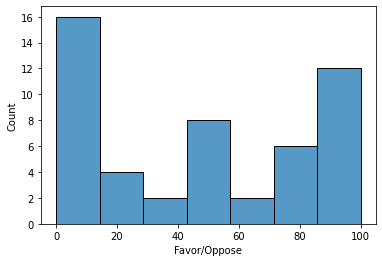

In [41]:
sns.histplot(Mturk['Favor/Oppose'].astype('int'))

In [44]:
Mturk['FO_irrelevant'] = Mturk['Answer.Q2']

In [48]:
Mturk['FO_irrelevant'].count()

12

In [49]:
Mturk['Likelihood_irrelevant'].count()

11

In [52]:
Mturk['Answer.Q3'].value_counts()

not at all difficult                                                26
Somewhat difficult                                                  17
I did not answer the question because the tweet was not relevant     5
Extremely difficult                                                  2
Name: Answer.Q3, dtype: int64

In [53]:
Mturk['Answer.Q4'].value_counts()

not at all difficult                                                30
Somewhat difficult                                                  13
I did not answer the question because the tweet was not relevant     6
Extremely difficult                                                  1
Name: Answer.Q4, dtype: int64

In [56]:
Mturk.columns

Index(['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward',
       'CreationTime', 'MaxAssignments', 'RequesterAnnotation',
       'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds',
       'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds',
       'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime',
       'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime',
       'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate',
       'Last30DaysApprovalRate', 'Last7DaysApprovalRate',
       'Input.UniversalMessageId', 'Input.citizen_distance', 'Input.full_text',
       'Answer.Q1', 'Answer.Q2', 'Answer.Q3', 'Answer.Q4', 'Answer.Q5',
       'Approve', 'Reject', 'Likelihood', 'Likelihood_irrelevant',
       'Favor/Oppose', 'FO_irrelevant'],
      dtype='object')

In [69]:
Mturk[['Input.UniversalMessageId','Input.full_text','WorkTimeInSeconds','Likelihood','Likelihood_irrelevant','Favor/Oppose','FO_irrelevant','Answer.Q3','Answer.Q4','Answer.Q5']].to_csv(r'C:\Users\Mao\sharedfiles\pilot_study_result.csv',index=False)

In [63]:
from scipy.stats import pearsonr
pearsonr(Mturk.groupby('Input.UniversalMessageId').Likelihood.first().astype(int),Mturk.groupby('Input.UniversalMessageId').Likelihood.last().astype(int))

(0.035968157282072026, 0.8644687691897438)

In [4]:
pilot_study = pd.read_csv(r"C:\Users\Mao\Downloads\Stance Detection_April 4, 2022_07.06.csv")

In [11]:
pilot_study

StartDate  \
0                                          Start Date   
1   {"ImportId":"startDate","timeZone":"America/De...   
2                                 2022-03-23 15:23:38   
3                                 2022-03-23 15:28:17   
4                                 2022-03-23 15:32:46   
5                                 2022-03-23 15:54:57   
6                                 2022-03-23 15:39:56   
7                                 2022-03-27 14:05:08   
8                                 2022-03-28 09:56:06   
9                                 2022-03-28 15:03:27   
10                                2022-03-29 10:45:17   
11                                2022-03-29 17:41:03   
12                                2022-03-30 13:03:38   
13                                2022-03-27 12:36:14   
14                                2022-03-27 15:23:55   
15                                2022-03-27 15:28:03   
16                                2022-04-03 21:42:59   
17                                2022-04-03 21:41:56   

                                              EndDate                 Status  \
0                                            End Date          Response Type   
1   {"ImportId":"endDate","timeZone":"America/Denv...  {"ImportId":"status"}   
2                                 2022-03-23 15:24:19         Survey Preview   
3                                 2022-03-23 15:29:37         Survey Preview   
4                                 2022-03-23 15:34:32             IP Address   
5                                 2022-03-23 21:14:13             IP Address   
6                                 2022-03-27 12:36:11             IP Address   
7                                 2022-03-27 15:19:05             IP Address   
8                                 2022-03-28 10:13:22             IP Address   
9                                 2022-03-28 16:08:52             IP Address   
10                                2022-03-29 11:13:11             IP Address   
11                                2022-03-29 17:54:28             IP Address   
12                                2022-03-30 13:26:10             IP Address   
13                                2022-03-27 12:36:20             IP Address   
14                                2022-03-27 15:27:54             IP Address   
15                                2022-03-27 16:50:12             IP Address   
16                                2022-04-03 21:56:25             IP Address   
17                                2022-04-03 22:02:45             IP Address   

                   IPAddress                 Progress  \
0                 IP Address                 Progress   
1   {"ImportId":"ipAddress"}  {"ImportId":"progress"}   
2                        NaN                      100   
3                        NaN                      100   
4              98.224.182.80                      100   
5              68.36.133.200                      100   
6              98.224.182.80                      100   
7              68.36.133.200                      100   
8              68.36.133.200                      100   
9             73.144.155.173                      100   
10            68.173.233.240                      100   
11              66.44.43.177                      100   
12             141.149.43.27                      100   
13             98.224.182.80                        5   
14             68.36.133.200                        1   
15             68.36.133.200                       96   
16              172.56.42.15                      100   
17             99.47.243.217                      100   

      Duration (in seconds)                 Finished  \
0     Duration (in seconds)                 Finished   
1   {"ImportId":"duration"}  {"ImportId":"finished"}   
2                        41                     True   
3                        79                     True   
4                       105                     True   
5                  

In [22]:
pilot_study.loc[16:,'Q2.2_1':'Q26.3_1'].transpose().dropna()

16   17
Q2.2_1   -50  -47
Q2.3_1    50   41
Q5.2_1     0    0
Q5.3_1    31   44
Q6.2_1     0    0
Q6.3_1     0   43
Q7.2_1     0    0
Q7.3_1     0   44
Q10.2_1  -50    0
Q10.3_1    0    0
Q11.2_1   21    0
Q11.3_1   11    0
Q12.2_1   23  -45
Q12.3_1   10    0
Q14.2_1  -50    0
Q14.3_1    0    0
Q15.2_1  -50  -44
Q15.3_1    0    0
Q16.2_1    0   35
Q16.3_1  -50  -43
Q18.2_1  -50  -45
Q18.3_1    0    0
Q19.2_1  -10  -35
Q19.3_1   50   45
Q20.2_1    0  -38
Q20.3_1    0   43
Q22.2_1   11   36
Q22.3_1   41   42
Q26.2_1   10   24
Q26.3_1  -50  -42

In [24]:
pilot_study.loc[16:,'Q2.2_1':'Q26.3_1'].transpose().isna().sum()

16    14
17    18
dtype: int64

In [26]:
pilot_study.loc[16:,'Q2.2_1':'Q26.3_1'].transpose().loc[pilot_study.loc[16:,'Q2.2_1':'Q26.3_1'].transpose()[16].isna()==pilot_study.loc[16:,'Q2.2_1':'Q26.3_1'].transpose()[17].isna(),:]

16   17
Q2.2_1   -50  -47
Q2.3_1    50   41
Q3.2_1   NaN  NaN
Q3.3_1   NaN  NaN
Q5.2_1     0    0
Q5.3_1    31   44
Q6.2_1     0    0
Q6.3_1     0   43
Q7.2_1     0    0
Q7.3_1     0   44
Q8.2_1   NaN  NaN
Q8.3_1   NaN  NaN
Q9.2_1   NaN  NaN
Q9.3_1   NaN  NaN
Q10.2_1  -50    0
Q10.3_1    0    0
Q11.2_1   21    0
Q11.3_1   11    0
Q12.2_1   23  -45
Q12.3_1   10    0
Q13.2_1  NaN  NaN
Q13.3_1  NaN  NaN
Q14.2_1  -50    0
Q14.3_1    0    0
Q15.2_1  -50  -44
Q15.3_1    0    0
Q16.2_1    0   35
Q16.3_1  -50  -43
Q17.2_1  NaN  NaN
Q17.3_1  NaN  NaN
Q18.2_1  -50  -45
Q18.3_1    0    0
Q19.2_1  -10  -35
Q19.3_1   50   45
Q20.2_1    0  -38
Q20.3_1    0   43
Q22.2_1   11   36
Q22.3_1   41   42
Q25.2_1  NaN  NaN
Q25.3_1  NaN  NaN
Q26.2_1   10   24
Q26.3_1  -50  -42